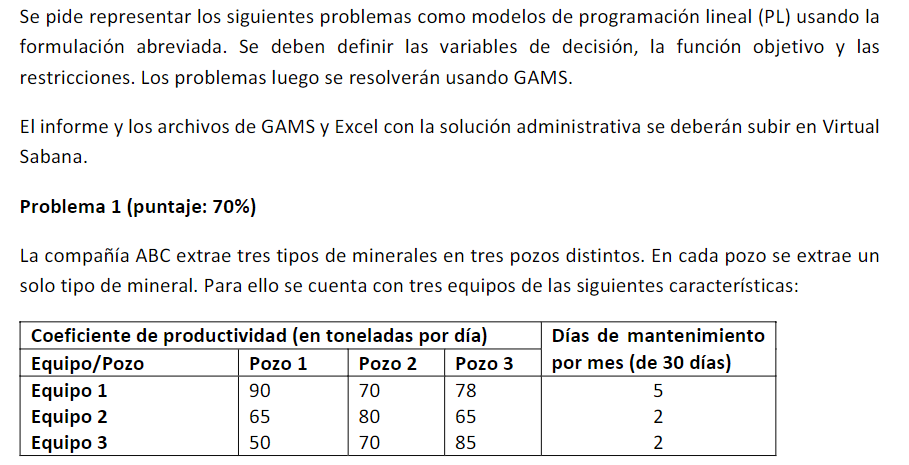

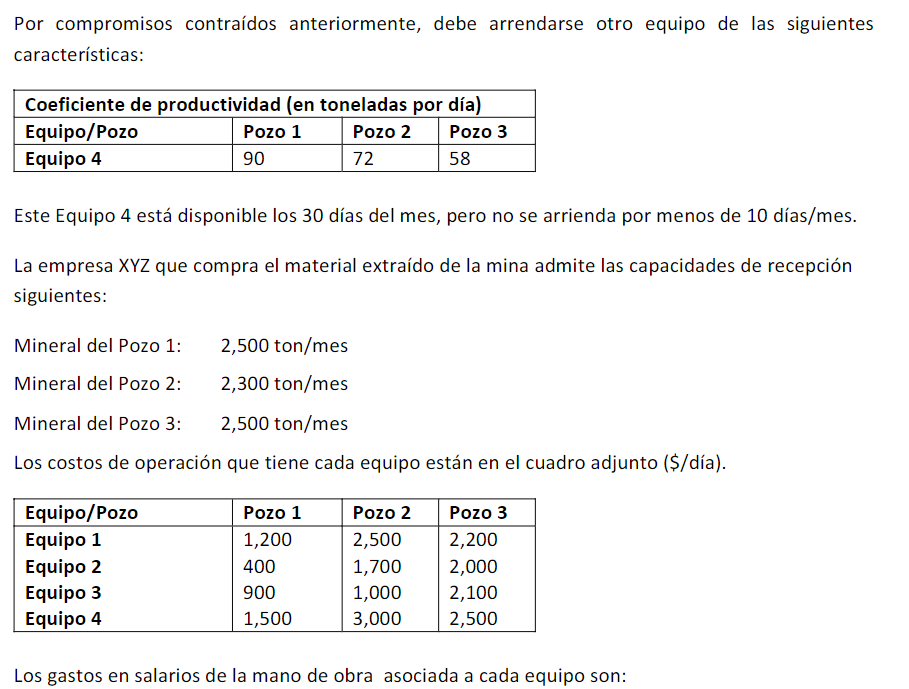

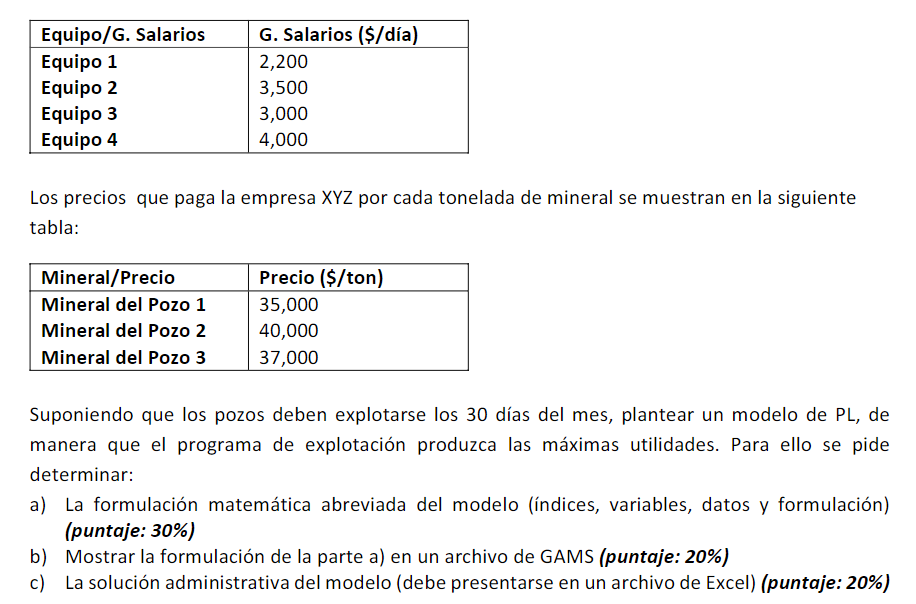

# Optimization model

#### Sets 
* $I$: Set of wells, i $\in$ {well 1, well 2, well 3}
* $J$: Set of equipments, j $\in$ {equipment 1, equipment 2, equipment 3}

#### Parameters
* $cp_{i,j}$: Is the amount of tons per day of the well mineral ${i}$ that are extracted from the equipment ${j}$, $\forall i \in I, \forall j \in J$
* $m_{j}$: Are the monthly maintenance days for the equipment ${j}$, $j = 1,2,3$
* $q_{i}$: Is the monthly maximum capacity for the well mineral ${i}$, $\forall i \in I$
* $cost^{op}_{i,j}$: Is the unit operation cost for the equipment ${j}$ in the well ${i}$, $\forall i \in I, \forall j \in J$
* $cost^{MO}_{j}$: Is the unit manpower cost for the equipment ${j}$, $\forall j \in J$
* $price_{i}$: Is the unit sell price for the well mineral ${i}$, $\forall i \in I $

#### Decision variables
* $x_{i,j}$: Is the amount of tons per month of the well mineral ${i}$ that are extracted from the equipment ${j}$, $\forall i \in I, \forall j \in J$


#### Objective function
$$\ Max\space \ Z = \sum_{i \in I} \sum_{j \in J} price_{i}*x_{i,j} - \frac {x_{i,j}}{cp_{i,j}}*(cost^{op}_{i,j}+cost^{MO}_{j}) $$

#### Constraints
Maintanance
$$ m_{j} \leq \sum_{i \in I} \frac{x_{i,j}}{cp_{i,j}} \leq 30, \forall j \in J$$
Capacity
$$ \sum_{j \in j} x_{i,j} \leq q_{i}, \forall i \in I$$
Non negative
$$ x_{i,j} \geq 0, \forall i \in I, \forall j \in J $$

## Code

In [1]:
import pyomo.environ as pe
import pyomo.opt as po

In [2]:
wells = {'well 1','well 2','well 3'}

equipments = {'equipment 1', 'equipment 2', 'equipment 3', 'equipment 4'}

productivity = {('well 1','equipment 1'): 90, ('well 1','equipment 2'): 65, ('well 1','equipment 3'): 50, ('well 1','equipment 4'): 90,
                ('well 2','equipment 1'): 70, ('well 2','equipment 2'): 80, ('well 2','equipment 3'): 70, ('well 2','equipment 4'): 72,
                ('well 3','equipment 1'): 78, ('well 3','equipment 2'): 65, ('well 3','equipment 3'): 85, ('well 3','equipment 4'): 58}

cost_op = {('well 1','equipment 1'): 1200, ('well 1','equipment 2'): 400,  ('well 1','equipment 3'): 900,  ('well 1','equipment 4'): 1500,
           ('well 2','equipment 1'): 2500, ('well 2','equipment 2'): 1700, ('well 2','equipment 3'): 1000, ('well 2','equipment 4'): 3000,
           ('well 3','equipment 1'): 2200, ('well 3','equipment 2'): 2000, ('well 3','equipment 3'): 2100, ('well 3','equipment 4'): 2500}

capacity = {'well 1': 2500, 'well 2': 2300, 'well 3':2500}

price = {'well 1': 35000, 'well 2': 40000, 'well 3':37000}

cost_MO = {'equipment 1':2200, 'equipment 2':3500, 'equipment 3':3000, 'equipment 4':4000}

maintanance = {'equipment 1':5, 'equipment 2':2, 'equipment 3':2, 'equipment 4':10}

In [3]:
#Sets
model = pe.ConcreteModel()
model.wells = pe.Set(initialize = wells)
model.equipments = pe.Set(initialize = equipments)

    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    data source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo


In [4]:
#Parameters
model.productivity = pe.Param(model.wells, model.equipments, initialize = productivity)
model.cost_op = pe.Param(model.wells, model.equipments, initialize = cost_op)
model.capacity = pe.Param(model.wells, initialize = capacity)
model.price = pe.Param(model.wells, initialize = price)
model.cost_MO = pe.Param(model.equipments, initialize = cost_MO)
model.maintanance = pe.Param(model.equipments, initialize = maintanance)

In [5]:
#Variables
model.x = pe.Var(model.wells, model.equipments, domain = pe.NonNegativeReals)

In [6]:
#Objective function
def calculate_profit(model):
    profit = sum(model.price[i] * model.x[i,j] - model.x[i,j]/model.productivity[i,j]*(model.cost_op[i,j] + model.cost_MO[j])\
                 for i in model.wells for j in model.equipments)
    return profit
model.obj_function_profit = pe.Objective(sense = pe.maximize, rule = calculate_profit)

In [7]:
model.obj_function_profit.pprint()

obj_function_profit : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : maximize : 40000*x[well 2,equipment 4] - 97.22222222222221*x[well 2,equipment 4] + 40000*x[well 2,equipment 2] - 65.0*x[well 2,equipment 2] + 40000*x[well 2,equipment 3] - 57.14285714285714*x[well 2,equipment 3] + 40000*x[well 2,equipment 1] - 67.14285714285714*x[well 2,equipment 1] + 37000*x[well 3,equipment 4] - 112.06896551724138*x[well 3,equipment 4] + 37000*x[well 3,equipment 2] - 84.61538461538461*x[well 3,equipment 2] + 37000*x[well 3,equipment 3] - 60.0*x[well 3,equipment 3] + 37000*x[well 3,equipment 1] - 56.41025641025641*x[well 3,equipment 1] + 35000*x[well 1,equipment 4] - 61.111111111111114*x[well 1,equipment 4] + 35000*x[well 1,equipment 2] - 60.0*x[well 1,equipment 2] + 35000*x[well 1,equipment 3] - 78.0*x[well 1,equipment 3] + 35000*x[well 1,equipment 1] - 37.77777777777778*x[well 1,equipment 1]


In [8]:
#Constraints
def maintanance(model, j):
    maintanance_left = model.maintanance[j]
    maintanance = sum(model.x[i,j]/model.productivity[i,j] for i in model.wells)
    maintanance_right = 30
    return (maintanance_left, maintanance, maintanance_right)
model.maintanance_constraint = pe.Constraint(model.equipments, rule = maintanance)

In [9]:
model.maintanance_constraint.pprint()

maintanance_constraint : Size=4, Index=equipments, Active=True
    Key         : Lower : Body                                                                                                                                 : Upper : Active
    equipment 1 :   5.0 :  0.014285714285714285*x[well 2,equipment 1] + 0.01282051282051282*x[well 3,equipment 1] + 0.011111111111111112*x[well 1,equipment 1] :  30.0 :   True
    equipment 2 :   2.0 :               0.0125*x[well 2,equipment 2] + 0.015384615384615385*x[well 3,equipment 2] + 0.015384615384615385*x[well 1,equipment 2] :  30.0 :   True
    equipment 3 :   2.0 :                 0.014285714285714285*x[well 2,equipment 3] + 0.011764705882352941*x[well 3,equipment 3] + 0.02*x[well 1,equipment 3] :  30.0 :   True
    equipment 4 :  10.0 : 0.013888888888888888*x[well 2,equipment 4] + 0.017241379310344827*x[well 3,equipment 4] + 0.011111111111111112*x[well 1,equipment 4] :  30.0 :   True


In [10]:
#Constraints
def capacity(model, i):
    capacity_left = sum(model.x[i,j] for j in model.equipments)
    capacity_right = model.capacity[i]
    constraint = (capacity_left <= capacity_right)
    return constraint
model.capacity_constraint = pe.Constraint(model.wells, rule = capacity)

In [11]:
model.capacity_constraint.pprint()

capacity_constraint : Size=3, Index=wells, Active=True
    Key    : Lower : Body                                                                                          : Upper  : Active
    well 1 :  -Inf : x[well 1,equipment 4] + x[well 1,equipment 2] + x[well 1,equipment 3] + x[well 1,equipment 1] : 2500.0 :   True
    well 2 :  -Inf : x[well 2,equipment 4] + x[well 2,equipment 2] + x[well 2,equipment 3] + x[well 2,equipment 1] : 2300.0 :   True
    well 3 :  -Inf : x[well 3,equipment 4] + x[well 3,equipment 2] + x[well 3,equipment 3] + x[well 3,equipment 1] : 2500.0 :   True


In [12]:
solver = pe.SolverFactory('glpk')
result = solver.solve(model, tee=True)
pe.value(model.obj_function_profit)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpgx0bl8j1.glpk.raw --wglp
 C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp0ttvie5x.glpk.glp --cpxlp C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmppmvdoi09.pyomo.lp
Reading problem data from 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmppmvdoi09.pyomo.lp'...
12 rows, 13 columns, 37 non-zeros
105 lines were read
Writing problem data to 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp0ttvie5x.glpk.glp'...
89 lines were written
GLPK Simplex Optimizer 5.0
12 rows, 13 columns, 37 non-zeros
Preprocessing...
11 rows, 12 columns, 36 non-zeros
Scaling...
 A: min|aij| =  1.111e-02  max|aij| =  1.000e+00  ratio =  9.000e+01
GM: min|aij| =  8.808e-01  max|aij| =  1.135e+00  ratio =  1.289e+00
EQ: min|aij| =  7.758e-01  max|aij| =  1.000e+00  ratio =  1.289e+00
Constructing initial basis...
Size of triangular part is 11
      0: obj =  -0.000000000e+00 inf =   1.268e+03 (4)
      4: 

271594969.93464065

In [13]:
model.x.pprint()

x : Size=12, Index=x_index
    Key                       : Lower : Value            : Upper : Fixed : Stale : Domain
    ('well 1', 'equipment 1') :     0 :           1600.0 :  None : False : False : NonNegativeReals
    ('well 1', 'equipment 2') :     0 :              0.0 :  None : False : False : NonNegativeReals
    ('well 1', 'equipment 3') :     0 :              0.0 :  None : False : False : NonNegativeReals
    ('well 1', 'equipment 4') :     0 :            900.0 :  None : False : False : NonNegativeReals
    ('well 2', 'equipment 1') :     0 :              0.0 :  None : False : False : NonNegativeReals
    ('well 2', 'equipment 2') :     0 : 1473.72549019608 :  None : False : False : NonNegativeReals
    ('well 2', 'equipment 3') :     0 : 826.274509803921 :  None : False : False : NonNegativeReals
    ('well 2', 'equipment 4') :     0 :              0.0 :  None : False : False : NonNegativeReals
    ('well 3', 'equipment 1') :     0 : 953.333333333333 :  None : False : False : 